# What's in a Name?

In this live code-along, we will explore a rich dataset of first names of babies born in the US, that spans a period of more than 100 years! This suprisingly simple dataset can help us uncover so many interesting stories, and that is exactly what we are going to be doing.

In [1]:
%%capture
!pip install html_table_extractor wget wquantiles 

## Import Libraries

In [2]:
# Import modules and functions
import numpy as np
import pandas as pd
from wquantiles import quantile

# Plotting libraries
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 6)
plt.style.use('seaborn-darkgrid')
import plotly.express as px

## Read Data

Let us start by reading the babynames data in `names.csv.gz`.

In [3]:
# Read data from names.csv.gz as a dataframe

babynames = pd.read_csv('names.csv.gz')
babynames.head()


name sex  births  year
0   Mary   F   54478  1959
1  Susan   F   41600  1959
2  Linda   F   40410  1959
3  Karen   F   36773  1959
4  Donna   F   36464  1959

## Explore Data

Although this dataset only has 4 columns, there are so many interesting questions one could explore. While the possibilities are endless, I have chosen six interesting questions, out of which we will explore a subset based on interest levels.

1. __Popular Names__: What are the most popular names?
2. __Trendy Names__: What are the most trendy names?
3. __Unisex Names__: What are the most unisex names?
4. __Length of Names__: How has the length of names changed over the years?
5. __Letters in Names__: What are the most common first and last letters?
6. __Estimate Age from Name__: How can we estimate a person's age from their name?

### Popular Names

One of the first things we want to do is to understand naming trends. Let us start by figuring out the top five most popular male and female names for this decade (born 2011 and later). Do you want to make any guesses? Go on, be a sport!!

In [4]:
# Get the five most popular male and female names of the decade starting in 2011.


popular_names = (
  babynames
    .query('year > 2010')
    [['name', 'sex', 'births']]
    .groupby(['sex','name'], as_index=False)
    .sum()
    .sort_values(['sex', 'births'])
    .groupby('sex')
    .tail(5)
)
popular_names


sex      name  births
4575    F       Ava  153254
13252   F  Isabella  159407
29677   F    Sophia  173226
25388   F    Olivia  184797
10380   F      Emma  192985
43875   M     Jacob  150015
50306   M     Mason  152832
57851   M   William  155180
49303   M      Liam  182448
51958   M      Noah  184785

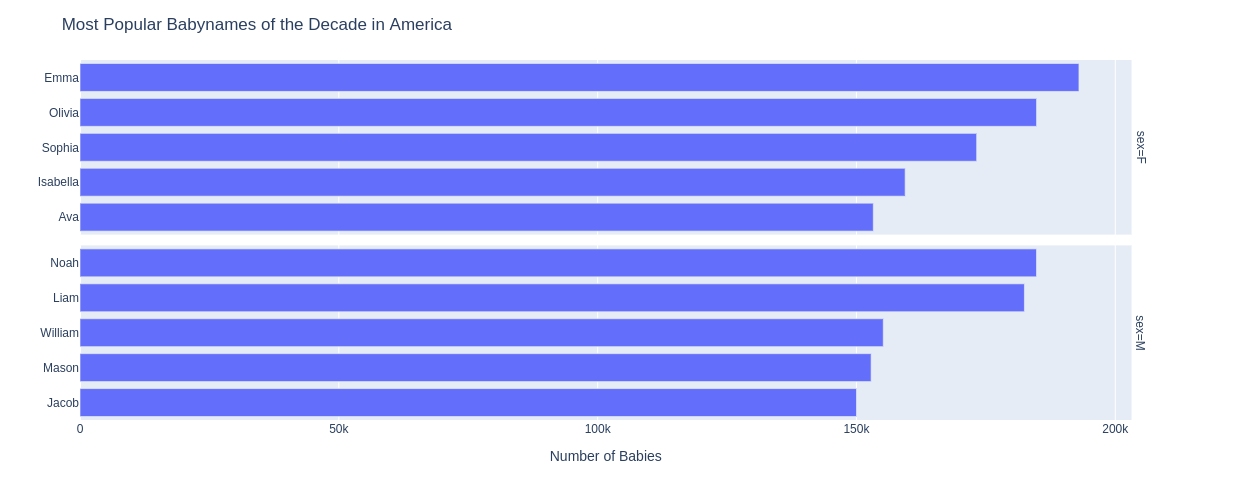

In [5]:
# Plot a horizontal bar plot of number of births by name facetted by sex

fig = px.bar(popular_names, x="births", y="name", facet_row="sex", orientation='h', height=500)
fig.update_layout(
    yaxis_title = None, 
    yaxis2_title = None,
    yaxis2_matches=None,
    xaxis_title = 'Number of Babies',
    title = 'Most Popular Babynames of the Decade in America'
)


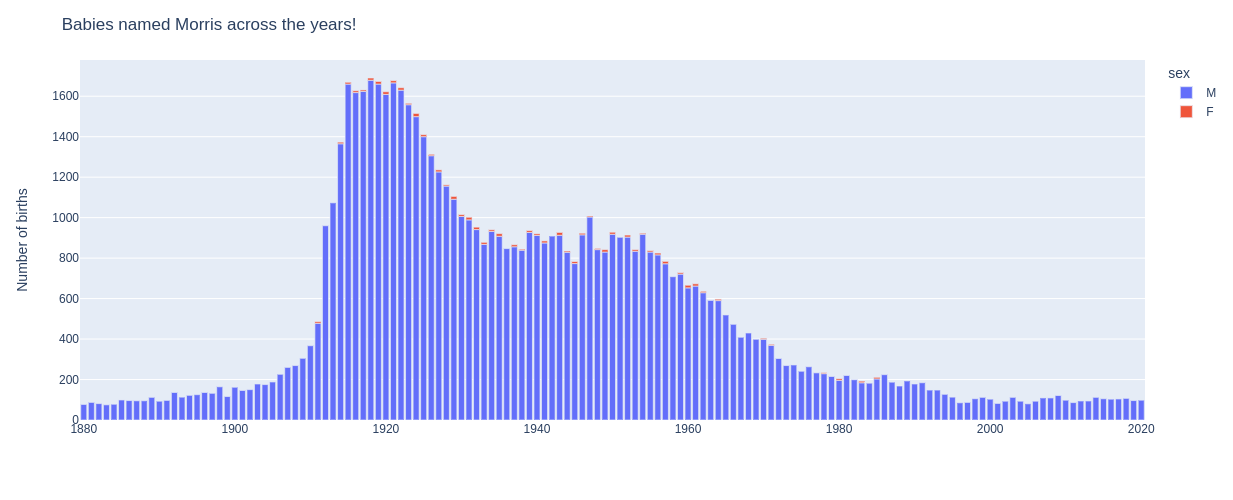

In [6]:
# Plot trend in the number of babies with a specific name

name = "Morris"
fig = px.bar(
    babynames
      .query("name == @name")
      .sort_values(by="year"),
    x='year', 
    y='births', 
    color='sex',
    height=500
)
fig.update_layout(
  title = f"Babies named {name} across the years!",
  yaxis_title = "Number of births",
  xaxis_title = None
)


### Trendy Names

A stable name is one whose proportion across years does not vary drastically, while a trendy name is one whose popularity peaks for a short period and then dies down. There are many ways to capture trendiness. A simple measure would be to look at the maximum proportion of births for a name, normalized by the sume of proportion of births across years. For example, if the name Joe had the proportions 0.1, 0.2, 0.1, 0.1, then the trendiness measure would be 0.2/(0.1 + 0.2 + 0.1 + 0.1) which equals 0.5. Let us use this idea to figure out the top 10 trendy names in this data set, with at least 5000 births.

In [7]:
# Get the top trendy names with more than 5000 births.
popular_trendy_names = (
  babynames[['sex', 'name', 'births']]
    .groupby(['sex', 'name'], as_index = False)
    .agg(
      births_total = ("births", "sum"),
      births_max = ("births", "max")
    )
    .query('births_total > 5000')
    .assign(trendiness = lambda x: x.births_max / x.births_total)
    .sort_values(['sex', 'trendiness'], ascending=False)
    .groupby('sex')
    .head(5)
)
popular_trendy_names


sex       name  births_total  births_max  trendiness
104289   M  Shaquille          5592        1784    0.319027
72237    M      Atlas          9322        2028    0.217550
93948    M     Legend         12976        2814    0.216862
87096    M       Jase         21464        4552    0.212076
94861    M       Luka         11178        2319    0.207461
1880     F      Alaia          6294        2254    0.358119
20948    F  Everleigh         10043        2799    0.278702
24816    F      Iesha          7432        1896    0.255113
6406     F    Ashanti         12038        2945    0.244642
32204    F     Katina         11273        2745    0.243502

### Unisex Names

There are some names that are used commonly by both the sexes. Let us dive into the data and figure out what are the most popular unisex names. Let us assume that a name is considered unisex if there are more than 33% males and 33% females with that name. We can tweak these thresholds subsequently to see if it reveals a different set of names!There are some names that are used commonly by both the sexes. Let us dive into the data and figure out what are the most popular unisex names. Let us assume that a name is considered unisex if there are more than 33% males and 33% females with that name. We can tweak these thresholds subsequently to see if it reveals a different set of names!

In [8]:
# Get names with more than 33% male and 33% females, sorted by births.
unisex_names = (
  babynames
    .groupby(['sex', 'name'], as_index=False)
    .sum()
    .pivot(index='name', columns='sex', values='births')
    .fillna(0)
    .assign(pct_M = lambda x: x.M / (x.M + x.F))
    .assign(pct_F = lambda x: x.F / (x.M + x.F))
    .assign(total = lambda x: x.F + x.M)
    .query('pct_M > 0.33 & pct_F > 0.33')
    .sort_values(by="total", ascending=False)
    .reset_index()
)
unisex_names.head()

sex    name         F         M     pct_M     pct_F     total
0    Jessie  168267.0  110561.0  0.396520  0.603480  278828.0
1     Riley  117958.0   97035.0  0.451340  0.548660  214993.0
2     Casey   76841.0  111726.0  0.592500  0.407500  188567.0
3    Jackie   90850.0   78608.0  0.463879  0.536121  169458.0
4    Peyton   77779.0   49865.0  0.390657  0.609343  127644.0

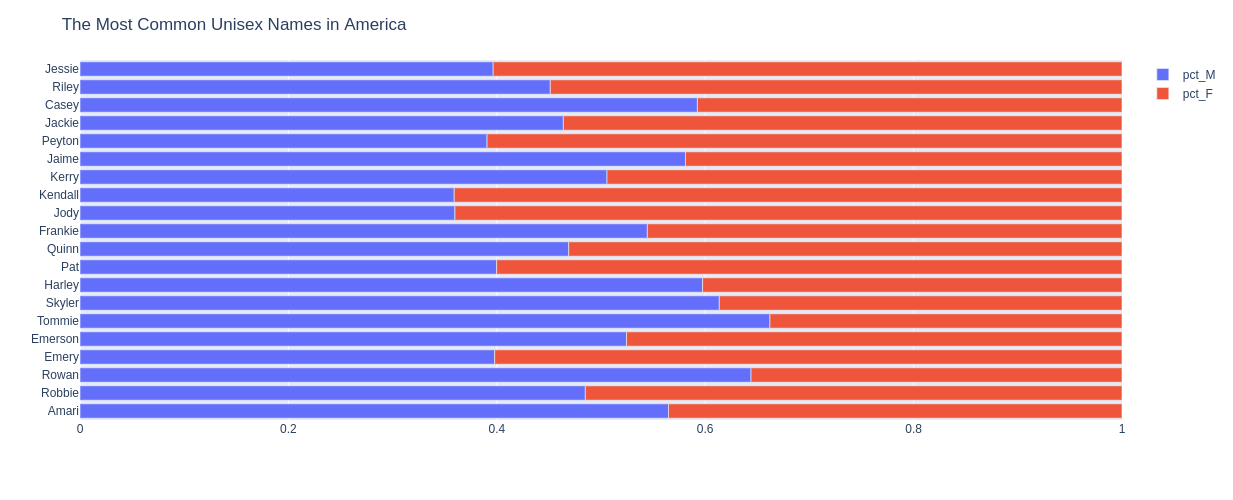

In [9]:
# Plot a horizontal stacked bar plot of the top 20 unisex names and the share of male vs. female
fig = px.bar(
  unisex_names
    .head(20)
    .iloc[::-1], 
  x=["pct_M", "pct_F"], 
  y="name", 
  orientation='h',
  height=500
)
fig.update_layout(
  title='The Most Common Unisex Names in America',
  xaxis_range=[0,1],
  yaxis_title=None,
  xaxis_title=None,
  legend_title=None
)
fig.update_traces(
  hovertemplate="%{value:.1%} named %{y}"
)
fig.show(config={"displayModeBar": False})


### Length of Names

Another interesting question to look at is the length of names. How long are male and female names and how has that length changed over the years? In order to answer this, we first need to compute the length of each name, and then inspect the distribution of name lengths across sex and year.

In [10]:
# Add a column with number of characters in the name
babynames = (
  babynames
    .assign(nchars = lambda x: [len(w) for w in x.name])
)
babynames.head()

name sex  births  year  nchars
0   Mary   F   54478  1959       4
1  Susan   F   41600  1959       5
2  Linda   F   40410  1959       5
3  Karen   F   36773  1959       5
4  Donna   F   36464  1959       5

We can start by computing the percentage of births by sex with a given number of characters, and plotting the distribution. 

In [11]:
# Compute the percentage of births by sex and number of characters in the name
nchars_by_sex = (
  babynames
    .groupby(['sex', 'nchars'])
    [['births']]
    .sum()
    .groupby(level='sex')
    .apply(lambda x: x / x.sum())
    .reset_index()
)
nchars_by_sex.head()


sex  nchars    births
0   F       2  0.001141
1   F       3  0.024709
2   F       4  0.128913
3   F       5  0.248671
4   F       6  0.236985

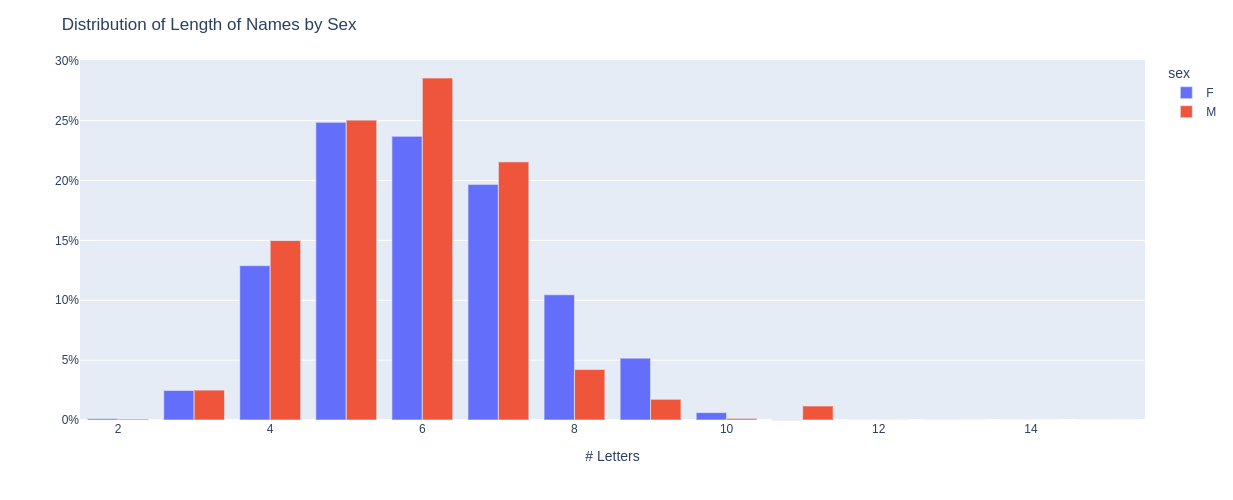

In [12]:
# Plot the distribution of name lengths by sex
fig = px.bar(nchars_by_sex, x='nchars', y='births', color='sex', barmode='group', height=500)
fig.update_layout(
  title='Distribution of Length of Names by Sex',
  xaxis_title = '# Letters',
  yaxis = dict(title=None, tickformat=",.0%")
)
fig.show(config={"displayModeBar": False})

We can also look at the average length of names by sex across years to see if names have become longer or shorter over time.

In [13]:
# Compute the weighted-average name length by sex and year
nchars_by_sex_year = (
   babynames
    .assign(nchars_births = lambda x: x.nchars * x.births)
    .groupby(['sex', 'year'])
    .apply(lambda x: x.nchars_births.sum() / x.births.sum())
    .reset_index(name="avg_nchars")
)
nchars_by_sex_year.head()


sex  year  avg_nchars
0   F  1880    5.408653
1   F  1881    5.398921
2   F  1882    5.406761
3   F  1883    5.410331
4   F  1884    5.407614

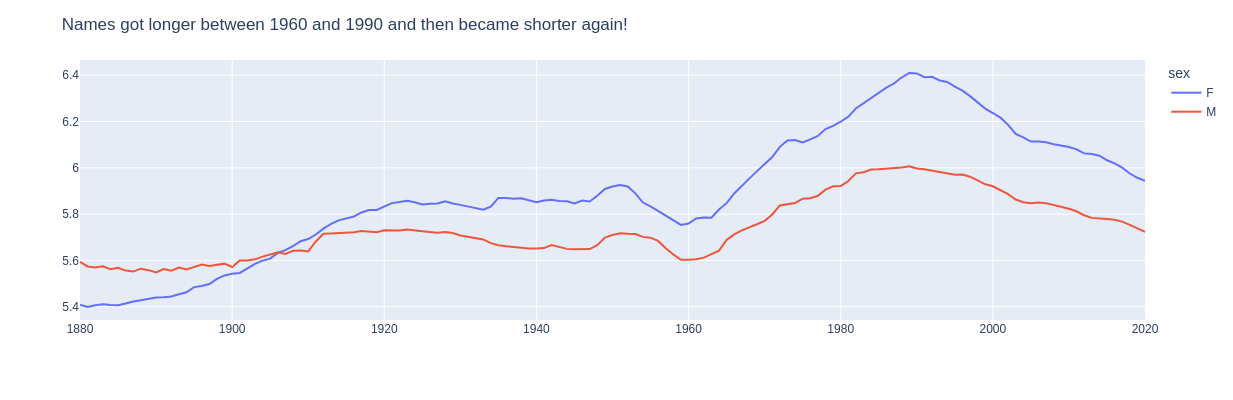

In [14]:
# Plot the trend in average name length by sex and year
fig = px.line(nchars_by_sex_year, x='year', y='avg_nchars', color='sex', height=400)
fig.update_layout(
  title='Names got longer between 1960 and 1990 and then became shorter again!',
  xaxis_title = None,
  yaxis_title = None
)
fig.show(config={"displayModeBar": False})

### Letters in Names

Just when you thought there is not much else you could do with this dataset, here is yet another interesting question to explore. 

1. How have the first and last letters in names changed over the years by sex? 
2. What are the trends in percentage of names with a given first or last letter across years. 
3. What are the most popular combinations of first and last letters?

In [15]:
# Add two columns, one for first_letter and one for last_letter
babynames = (
  babynames
   .assign(first_letter = lambda x: [w[0] for w in x.name])
   .assign(last_letter = lambda x: [w[-1].upper() for w in x.name])
)
babynames.head()

name sex  births  year  nchars first_letter last_letter
0   Mary   F   54478  1959       4            M           Y
1  Susan   F   41600  1959       5            S           N
2  Linda   F   40410  1959       5            L           A
3  Karen   F   36773  1959       5            K           N
4  Donna   F   36464  1959       5            D           A

Let us start by looking at the distribution of births across year and sex by first letter of a name, and plotting the distribution for a given year.

In [16]:
# Compute percentage of names with a given first letter by year and sex
# year | sex | first_letter | pct_births
by_first_letter = (
  babynames
   .groupby(['year', 'sex', 'first_letter'])
   [['births']]
   .sum()
   .groupby(level=['sex', 'year'])
   .apply(lambda x: x / x.sum())
   .reset_index()
   .sort_values(by=["year", "sex", "births"], ascending=[True, True, False])
) 
by_first_letter.head()



year sex first_letter    births
12  1880   F            M  0.217377
4   1880   F            E  0.125767
0   1880   F            A  0.102578
11  1880   F            L  0.095754
2   1880   F            C  0.064488

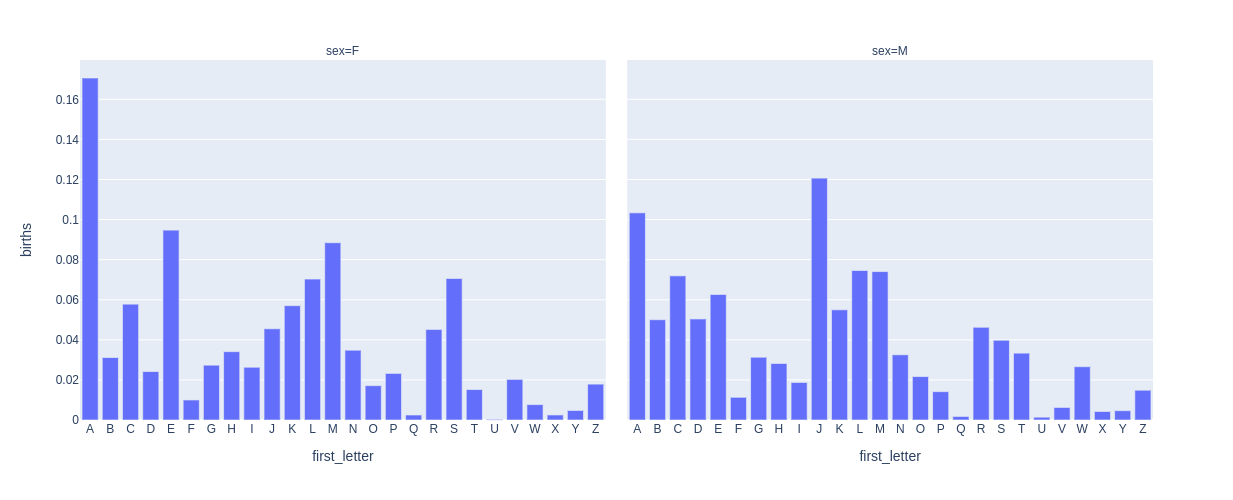

In [17]:
# Plot the distribution of births by first letter for the year 2020 facetted by sex.
fig = px.bar(
    by_first_letter.query("year == 2020"),  
    x='first_letter', 
    y='births', 
    facet_col='sex', 
    category_orders=dict(first_letter=list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")),
    height=500
)
fig.update_layout(
    xaxis2_matches=None
)
fig

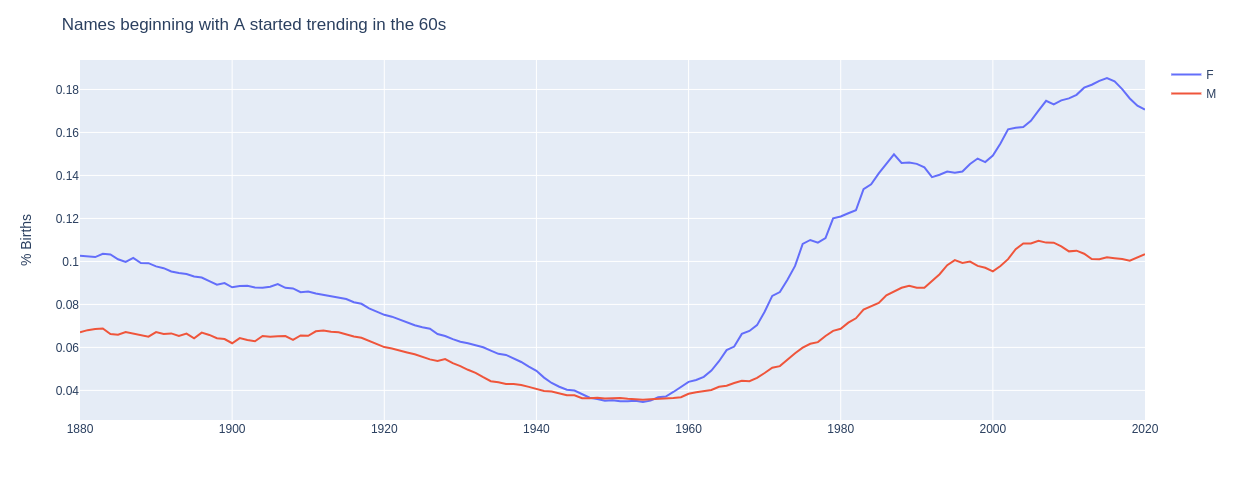

In [18]:
# Plot trends in percentage of births with a name starting with "A"
fig = px.line(
  by_first_letter.query('first_letter == "A"'),
  x = 'year',
  y = 'births',
  color='sex',
  height=500
)
fig.update_layout(
  title='Names beginning with A started trending in the 60s',
  xaxis_title=None,
  yaxis_title="% Births",
  legend_title=None
)
fig


Let us now look at the joint distribution of births by first and last letter to explore what are the most popular combinations, and how they have changed over years.

In [19]:
# Compute the percentage of births in each year by first and last letter, for Females or Males.
# first_letter | last_letter | year | pct_births
by_first_and_last_letter = (
   babynames
     .query('sex == "F"')
     .groupby(['first_letter', 'last_letter', 'year'])
     [['births']]
     .sum()
     .groupby(level="year", as_index=False)
     .apply(lambda x: x.births/x.births.sum())
     .reset_index()
     .drop(columns=['level_0'])
     .sort_values(by=['year', 'first_letter', 'last_letter'])
)
by_first_and_last_letter.head()


first_letter last_letter  year    births
0            A           A  1880  0.052575
1            A           E  1880  0.040321
2            A           H  1880  0.000264
3            A           L  1880  0.000275
4            A           N  1880  0.001506

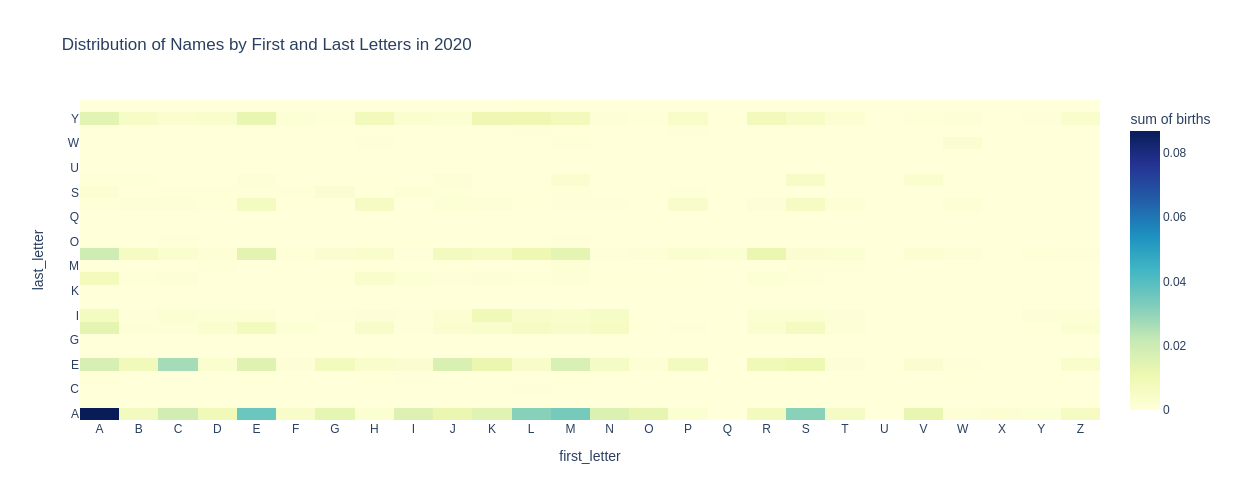

In [20]:
# Plot a heatmap of percentage of births by first letter and last letter for the year 2020
px.density_heatmap(
   by_first_and_last_letter.query('year == 2020'), 
   x='first_letter', 
   y='last_letter', 
   z='births', 
   category_orders=dict(
       first_letter=list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"),
       last_letter=list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")[::-1]
   ),
   color_continuous_scale="ylgnbu", 
   height=500,
   width=800,
   title="Distribution of Names by First and Last Letters in 2020"
)


### Estimate Age

So, what more is in a name? Well, with some further work, it is possible to predict the age of a person based on the name (Whoa! Really????). For this, we will need actuarial data that can tell us the chances that someone is still alive, based on when they were born. Fortunately, the [SSA](https://www.ssa.gov/) provides detailed [actuarial life tables](https://www.ssa.gov/oact/NOTES/as120/LifeTables_Tbl_7_1910.html) by birth cohorts.


| year| age|      qx|    lx|  dx|    Lx|      Tx|    ex|sex |
|----:|---:|-------:|-----:|---:|-----:|-------:|-----:|:---|
| 1910|  39| 0.00283| 78275| 222| 78164| 3129636| 39.98|F   |
| 1910|  40| 0.00297| 78053| 232| 77937| 3051472| 39.09|F   |
| 1910|  41| 0.00318| 77821| 248| 77697| 2973535| 38.21|F   |
| 1910|  42| 0.00332| 77573| 257| 77444| 2895838| 37.33|F   |
| 1910|  43| 0.00346| 77316| 268| 77182| 2818394| 36.45|F   |
| 1910|  44| 0.00351| 77048| 270| 76913| 2741212| 35.58|F   |


The key column of interest to us is `lx`, which provides the number of people born in a `year` who live upto a given `age`. The probability of being alive can be derived as `lx` by 100,000. You can read the [documentation for the lifetables](https://www.ssa.gov/oact/NOTES/as120/LifeTables_Body.html) to understand what the other columns mean. 

Let us read lifetables data from `lifetables.csv` and plot it to get a sense of the mortality distribution!

In [21]:
# Read lifetables data from lifetables.csv

# Read lifetables data from lifetables.csv
lifetables = pd.read_csv('lifetables.csv')
lifetables.head()


age       qx       lx      dx       Lx         Tx     ex sex  year
0  1.0  0.03282  85404.0  2803.0  84003.0  5061484.0  59.26   M  1900
1  2.0  0.01634  82601.0  1350.0  81926.0  4977482.0  60.26   M  1900
2  3.0  0.01052  81251.0   855.0  80824.0  4895556.0  60.25   M  1900
3  4.0  0.00875  80397.0   703.0  80045.0  4814732.0  59.89   M  1900
4  5.0  0.00628  79693.0   501.0  79443.0  4734687.0  59.41   M  1900

Given that 2020 is the latest year in the baby names dataset, we are interested only in a subset of this data, that will help us answer the question "What percentage of people born in Year X were still alive in 2020?"

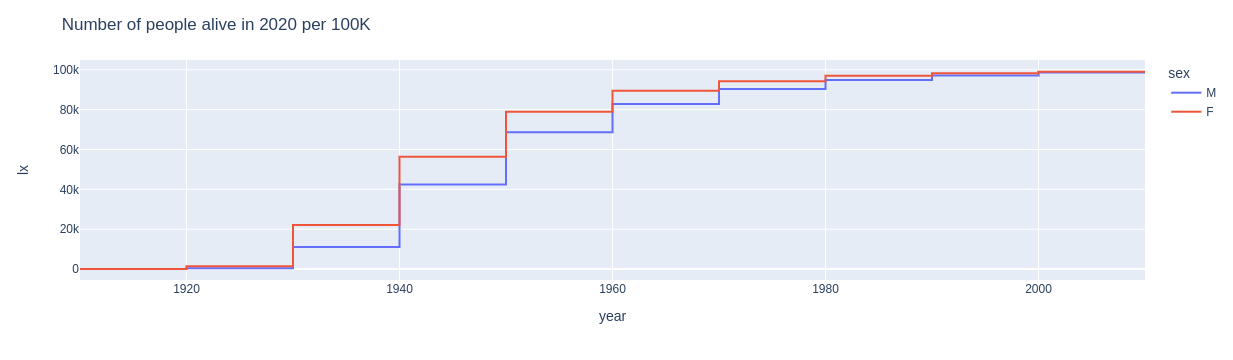

In [22]:
# Plot the survival curve of the number of people born in a year who will live up to 2020

lifetable_2020 = lifetables.query("age + year == 2020")
fig = px.line(lifetable_2020, x = "year", y="lx", color='sex')
fig.update_traces(line={"shape": 'hv'})
fig.update_layout(
    title='Number of people alive in 2020 per 100K'
)


We are almost there. There is just one small glitch. The cohort life tables are provided only for every decade. In order to figure out the distribution of people alive, we need the probabilities for every year. One way to fill up the gaps in the data is to use some kind of interpolation. Let us keep things simple and use linear interpolation to fill out the gaps in values of `lx`, between the years `1900` and `2020`.

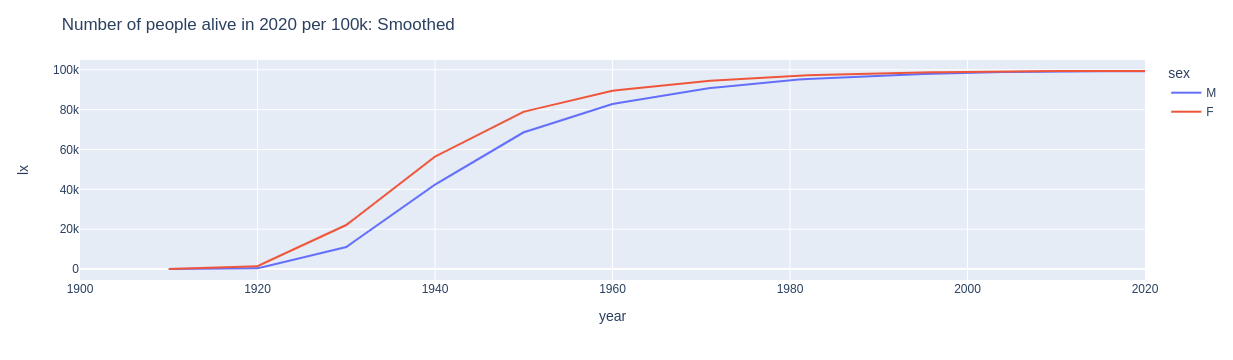

In [23]:
# Smooth lifetable_2020 by imputing missing values using interpolation.

lifetable_2020_s = (
  lifetable_2020[['year', 'sex', 'lx']]
    .set_index(["year", "sex"])
    .reindex(pd.MultiIndex.from_product(
        [range(1900, 2021), ['M', 'F']],
        names = ['year', 'sex']
    ))
    .groupby('sex')
    .apply(lambda x: x.interpolate())
    .reset_index()
)
fig = px.line(lifetable_2020_s, x="year", y="lx", color="sex")
fig.update_layout(
  title='Number of people alive in 2020 per 100k: Smoothed'
)



Let us now write a function that takes the births data for a given `name` and `sex`, merges it with the smoothed lifetables data and computes the number of people who are alive and dead.

In [24]:
# Function to compute number of people alive/dead for a given name and sex
# name | sex | age | n_alive | n_dead
def age_alive_dead(name, sex):
    return (
      babynames
        .query("name == @name & sex == @sex")
        .merge(lifetable_2020_s)
        .rename(columns={'lx': 'alive'})
        .assign(n_alive = lambda x: x.births*(x.alive/10**5))
        .assign(n_dead = lambda x: x.births - x.n_alive)
        .assign(pct_alive = lambda x: x.n_alive / x.births)
        .assign(age = lambda x: 2020 - x.year)
        .sort_values(by='age')
        .reset_index(drop=True)
        .dropna()
        [['name', 'sex', 'age', 'n_alive', 'n_dead']]
    )

age_alive_dead_anna = age_alive_dead("Anna", "F")
age_alive_dead_anna.head()



name sex  age    n_alive   n_dead
0  Anna   F    0  3457.0823  21.9177
1  Anna   F    1  3799.9088  24.0912
2  Anna   F    2  4153.6660  26.3340
3  Anna   F    3  4524.3161  28.6839
4  Anna   F    4  4762.8041  30.1959

Let us use this function to compute and plot the age distribution of people with a specific name.

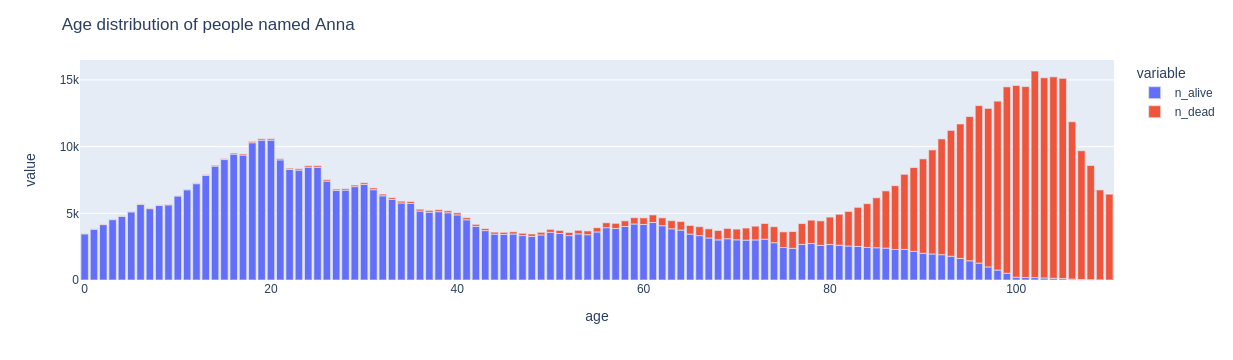

In [25]:
# Plot the age distribution of people named Anna
fig = px.bar(age_alive_dead_anna, x='age', y=['n_alive', 'n_dead'])
fig.update_layout(
  title = 'Age distribution of people named Anna'
)


In this section, we want to figure out the probability that a person with a certain name is alive, as well as the quantiles of their age distribution. In particular, we will estimate the age of a female named __Gertrude__. Any guesses on how old a person with this name is? How about a male named __William__?

We will start by writing a function that estimates the quantiles of the age distribution for people with a given `name` and `sex`.

In [26]:
# Function to estimate age quantiles from name and sex
def estimate_age(name, sex):
    d = age_alive_dead(name, sex)
    result = dict(name=name, sex=sex)
    result.update({'q' + str(q): quantile(d.age, d.n_alive, q/100) for q in [25, 50, 75]})
    return result
    
pd.DataFrame([estimate_age('Anna', 'F')])


name sex        q25        q50        q75
0  Anna   F  17.475237  31.057323  57.278875

Let us now get the top 25 most popular names for both sexes.

In [27]:
# Get top 25 most popular names for both sexes
popular_names_all_time = (
  babynames
    .groupby(['sex', 'name'])
    [['births']]
    .sum()
    .sort_values(by=["sex", "births"])
    .groupby('sex')
    .tail(25)
    .reset_index()
)
popular_names_all_time.head()


sex      name  births
0   F  Michelle  812630
1   F     Carol  816518
2   F      Ruth  827582
3   F     Donna  831114
4   F  Kimberly  839976

We can now estimate age quantiles of the most popular names and plot them!

In [28]:
# Estimate age quantiles of most popular names
# name | sex | q25 | q50 | q75
popular_names_age = pd.DataFrame([estimate_age(d.name, d.sex) for d in popular_names_all_time.to_records()])
popular_names_age.head()


name sex        q25        q50        q75
0  Michelle   F  34.040068  45.137069  51.865078
1     Carol   F  60.602850  68.527624  75.180701
2      Ruth   F  55.100999  68.923539  80.168736
3     Donna   F  56.449276  62.498362  69.812820
4  Kimberly   F  34.222790  46.117371  53.204845

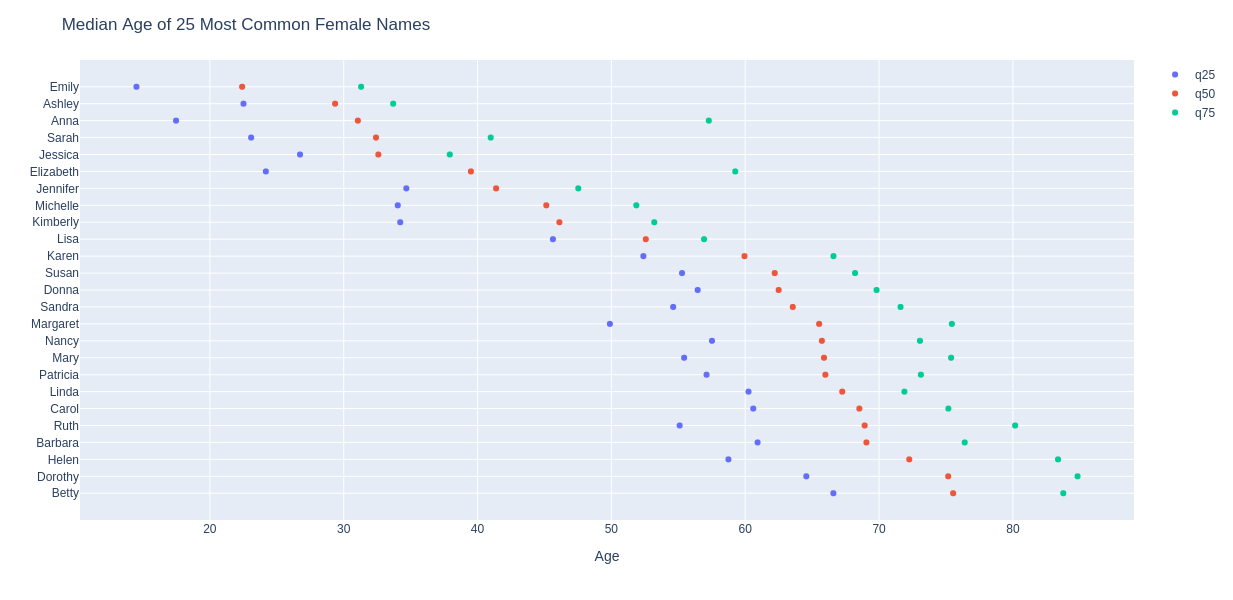

In [29]:
# Plot age quantiles by name
fig = px.scatter(
    popular_names_age
      .query("sex == 'F'")
      .sort_values(by="q50", ascending=False),
    y='name', 
    x=['q25', 'q50', 'q75'], 
    height=600
)
fig.update_layout(
  title='Median Age of 25 Most Common Female Names',
  yaxis_title=None,
  xaxis_title='Age',
  legend_title=None
)


## Next Steps

Hope this code-along motivated you to learn data-science, use DataCamp Workspace, and unearth interesting insights about names. If you want to pursue your recently-discovered passion for names, we have another interesting dataset of babynames, from France, which we have conveniently wrapped into a workspace template. Click on the link below to get started, and please share with us any intersting publications you create. Happy Workspacing!

[French Babynames Dataset Template](https://app.datacamp.com/workspace/new?_tag=template&templateKey=python-dataset-french-babynames?utm_source=workspace&utm_medium=in_product&utm_campaign=live-code-along&utm_term=codealong-python-us-babynames&utm_content=next-steps)